#### 1. Prepare env

In [45]:
#pip install numpy pandas matplotlib seaborn opencv-python scikit-learn torch torchvision pytorch-lightning albumentations fastai streamlit

1. Załaduj obrazy i zbierz ich wymiary
Najpierw załaduj obrazy z katalogów i odczytaj ich wymiary przy użyciu Pillow lub OpenCV.

In [62]:
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

N = 6 #WAŻNE - iteracja analizy zbioru danych - każda kolejna iteracja analizy zbioru powinna być wyższa od wcześniejszej. 

# Ścieżka do katalogu z danymi
data_dir = Path("/media/512GB_ext/preprocesed_dataset/")

# Zbieranie wymiarów obrazów
image_data = []
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        for img_path in class_dir.glob("*.*"):  # Wczytuj wszystkie obrazy
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    image_data.append({"class": class_name, "width": width, "height": height, "path": str(img_path)})
            except Exception as e:
                print(f"Błąd wczytywania obrazu: {img_path}, {e}")

# Przechowywanie danych w DataFrame
df = pd.DataFrame(image_data)
print(df.head())


   class  width  height                                               path
0  basil    232     630  /media/512GB_ext/preprocesed_dataset/basil/328...
1  basil    223     491  /media/512GB_ext/preprocesed_dataset/basil/351...
2  basil    220     694  /media/512GB_ext/preprocesed_dataset/basil/373...
3  basil    210     505  /media/512GB_ext/preprocesed_dataset/basil/305...
4  basil    234     638  /media/512GB_ext/preprocesed_dataset/basil/305...


2. Analiza rozkładu wymiarów
2.1. Podstawowe statystyki
Policz podstawowe statystyki wymiarów:

In [63]:
print(df.describe())

               width         height
count  301930.000000  301930.000000
mean      232.262551     561.348392
std        16.783705      74.928957
min       150.000000     340.000000
25%       221.000000     511.000000
50%       232.000000     543.000000
75%       243.000000     608.000000
max       310.000000     884.000000


2.2. Wizualizacja rozkładu szerokości i wysokości
Za pomocą wykresów histogramów lub rozkładów możesz sprawdzić, czy wymiary są zgodne z oczekiwaniami:

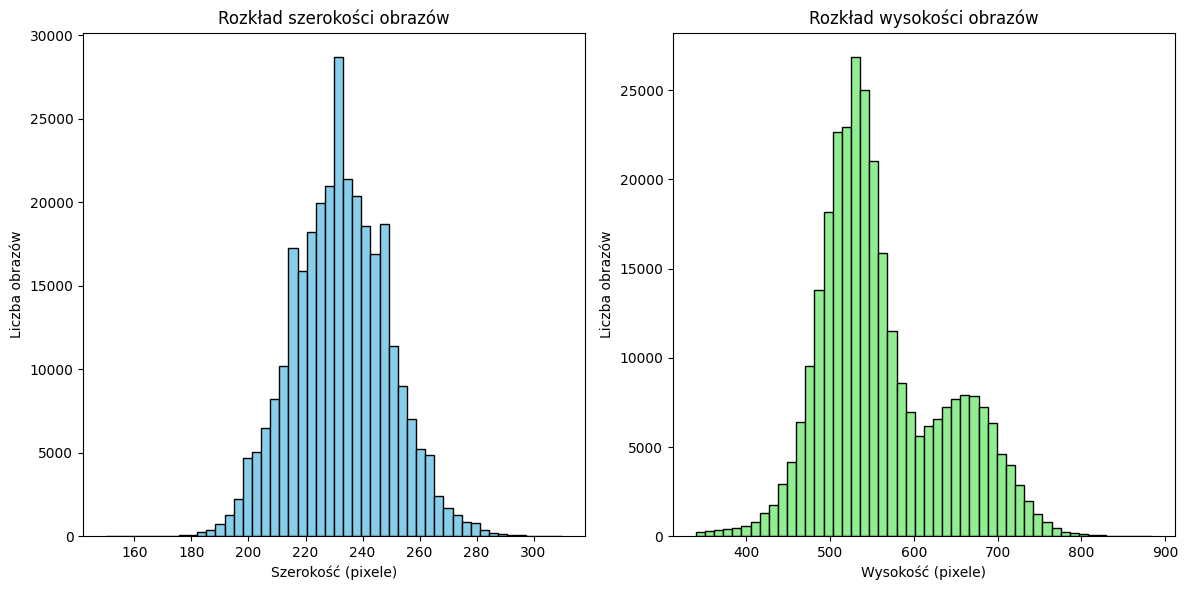

In [64]:
plt.figure(figsize=(12, 6))

# Histogram dla szerokości
plt.subplot(1, 2, 1)
plt.hist(df['width'], bins=50, color='skyblue', edgecolor='black')
plt.title("Rozkład szerokości obrazów")
plt.xlabel("Szerokość (pixele)")
plt.ylabel("Liczba obrazów")

# Histogram dla wysokości
plt.subplot(1, 2, 2)
plt.hist(df['height'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Rozkład wysokości obrazów")
plt.xlabel("Wysokość (pixele)")
plt.ylabel("Liczba obrazów")

plt.tight_layout()
plt.show()


2.3. Wizualizacja zależności między szerokością a wysokością
Przydatny może być scatter plot, który pokaże, jak szerokości i wysokości są rozłożone względem siebie:

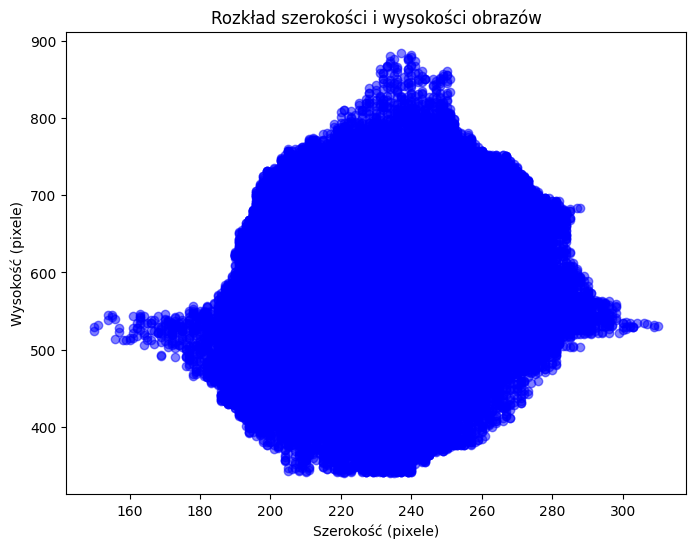

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(df['width'], df['height'], alpha=0.5, c='blue')
plt.title("Rozkład szerokości i wysokości obrazów")
plt.xlabel("Szerokość (pixele)")
plt.ylabel("Wysokość (pixele)")
plt.show()


3. Identyfikacja przypadków odstających
3.1. Wyznaczenie progów za pomocą IQR (Interquartile Range)
Możesz wykorzystać metodę IQR do identyfikacji obrazów o nietypowych wymiarach:

In [66]:
# Oblicz IQR dla szerokości i wysokości
Q1_width = df['width'].quantile(0.25)
Q3_width = df['width'].quantile(0.75)
IQR_width = Q3_width - Q1_width

Q1_height = df['height'].quantile(0.25)
Q3_height = df['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height

# Wyznacz dolne i górne granice
lower_bound_width = Q1_width - 1.5 * IQR_width
upper_bound_width = Q3_width + 1.5 * IQR_width

lower_bound_height = Q1_height - 1.5 * IQR_height
upper_bound_height = Q3_height + 1.5 * IQR_height

# Filtruj przypadki odstające
outliers = df[
    (df['width'] < lower_bound_width) | (df['width'] > upper_bound_width) |
    (df['height'] < lower_bound_height) | (df['height'] > upper_bound_height)
]

print(f"Liczba przypadków odstających: {len(outliers)}")
print(outliers)


Liczba przypadków odstających: 5143
                class  width  height  \
47              basil    283     622   
237             basil    284     645   
254             basil    228     348   
346             basil    185     520   
603             basil    278     547   
...               ...    ...     ...   
301798  ziarna_zdrowe    278     655   
301858  ziarna_zdrowe    247     793   
301861  ziarna_zdrowe    249     756   
301911  ziarna_zdrowe    245     807   
301928  ziarna_zdrowe    280     686   

                                                     path  
47      /media/512GB_ext/preprocesed_dataset/basil/305...  
237     /media/512GB_ext/preprocesed_dataset/basil/306...  
254     /media/512GB_ext/preprocesed_dataset/basil/306...  
346     /media/512GB_ext/preprocesed_dataset/basil/306...  
603     /media/512GB_ext/preprocesed_dataset/basil/307...  
...                                                   ...  
301798  /media/512GB_ext/preprocesed_dataset/ziarna_zd...  
301

3.2. Wyświetlenie przypadków odstających
Możesz załadować i wyświetlić przypadki odstające w celu ich analizy:

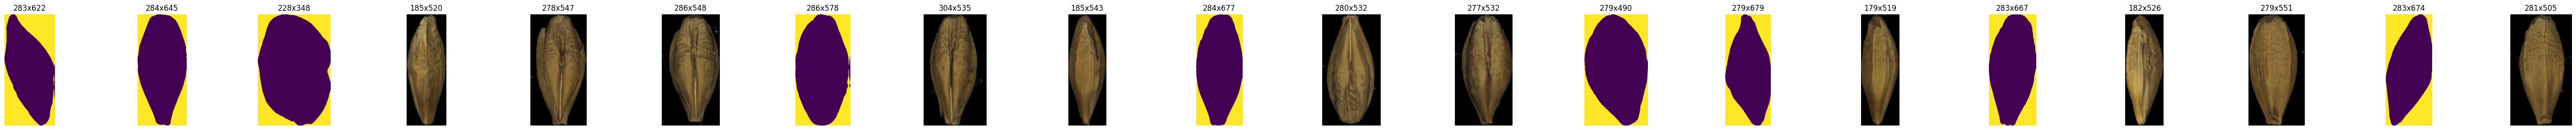

In [70]:
import matplotlib.pyplot as plt
from PIL import Image

# Wyświetl kilka przypadków odstających
def show_outliers(outliers_df, n=10):
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 3))
    for i, (_, row) in enumerate(outliers_df.iterrows()):
        if i >= n:
            break
        img = Image.open(row['path'])
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{row['width']}x{row['height']}")
    plt.tight_layout()
    plt.show()

show_outliers(outliers, 20)


4. Wizualizacja rozkładu dla poszczególnych klas
Możesz również sprawdzić, czy wymiary różnią się między klasami:

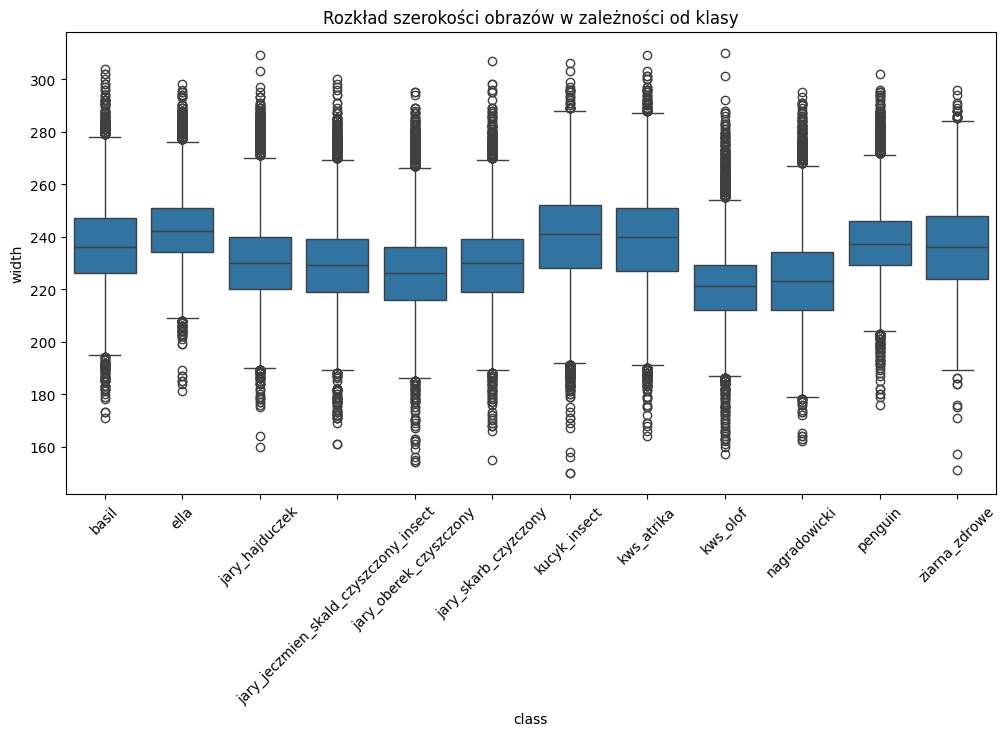

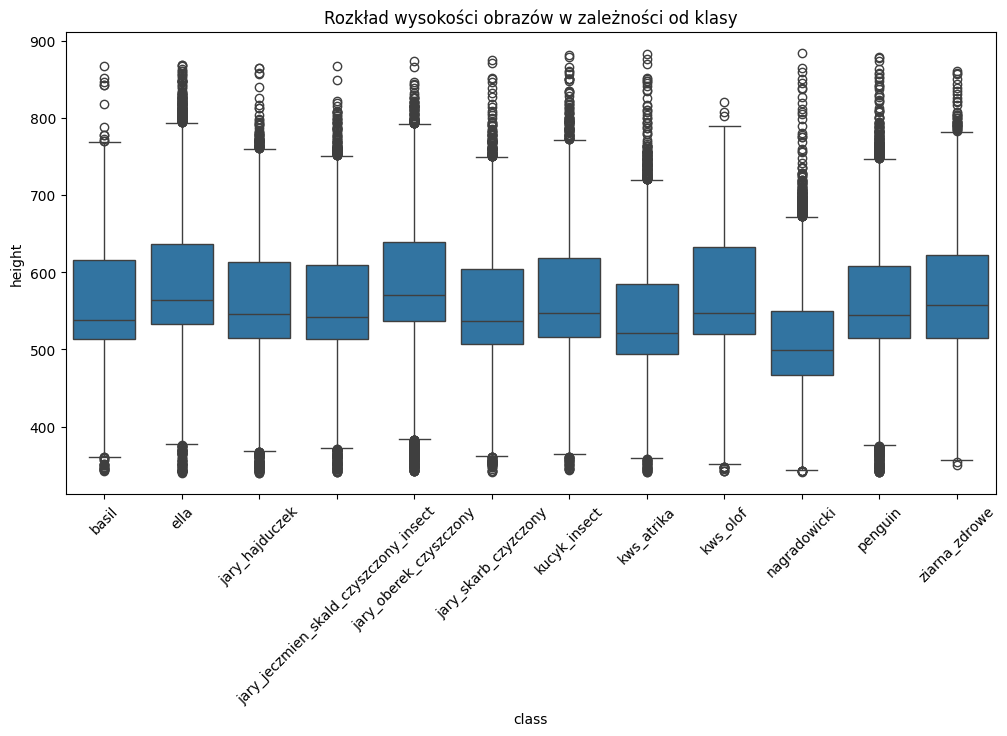

In [72]:
import seaborn as sns

# Rozkład szerokości w zależności od klasy
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='width')
plt.title("Rozkład szerokości obrazów w zależności od klasy")
plt.xticks(rotation=45)
plt.show()

# Rozkład wysokości w zależności od klasy
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='height')
plt.title("Rozkład wysokości obrazów w zależności od klasy")
plt.xticks(rotation=45)
plt.show()


Oznacz odstające obrazy: Możesz dodać kolumnę w DataFrame, aby oznaczyć obrazy, które wymagają uwagi:

In [53]:
df['is_outlier'] = False
df.loc[outliers.index, 'is_outlier'] = True

Eksportuj listę odstających przypadków: Zapisz szczegóły tych obrazów do pliku CSV:

In [54]:
outliers.to_csv(f"outliers{N}.csv", index=False)

5.1. Eksportuj wyniki analizy do CSV
Po wykonaniu wszystkich obliczeń i detekcji odstających przypadków, zapisz wyniki do pliku CSV, który ułatwi dalszą pracę:

In [55]:
df.to_csv(f"dataset_analysis{N}.csv", index=False)

5.2. Automatyczne grupowanie outlierów
Możesz wykorzystać algorytmy takie jak DBSCAN lub Isolation Forest do automatycznego grupowania odstających przypadków:

In [56]:
from sklearn.ensemble import IsolationForest

# Wyodrębnienie wymiarów
dims = df[['width', 'height']].values

# Model Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df['outlier_score'] = iso.fit_predict(dims)

# Zapisz wyniki
df['is_outlier'] = df['outlier_score'] == -1
df.to_csv(f"outliers_detected{N}.csv", index=False)


In [57]:
import pandas as pd

# Wczytaj plik CSV
input_csv = f"outliers_detected{N}.csv"  # Ścieżka do oryginalnego pliku
output_csv = f"outliers_detected_out{N}.csv"  # Ścieżka do pliku wynikowego

# Wczytaj dane
df = pd.read_csv(input_csv)

# Grupowanie obrazów na podstawie wspólnego identyfikatora (przed sufiksem *_T.png, *_B.png, *_S.png)
# Wyciągnij identyfikator obiektu (ścieżka bez końcówki "_T", "_B", "_S")
df['object_id'] = df['path'].str.replace(r'_[TBS]\.png$', '', regex=True)

# Sprawdź, czy dla danego obiektu jakikolwiek widok jest outlierem
outlier_objects = df[df['is_outlier'] == True]['object_id'].unique()

# Ustaw is_outlier = True dla wszystkich widoków tych obiektów
df['is_outlier'] = df['object_id'].isin(outlier_objects)

# Zapisz wynik do nowego pliku CSV
df.drop(columns=['object_id'], inplace=True)  # Usuń dodatkową kolumnę pomocniczą
df.to_csv(output_csv, index=False)

print(f"Zapisano wynik do pliku: {output_csv}")


Zapisano wynik do pliku: outliers_detected_out5.csv


In [ ]:
import os
import shutil
from pathlib import Path
import pandas as pd

def move_outliers(csv_file, destination_root):
    """
    Przenosi pliki z is_outlier=True do nowego katalogu, zachowując strukturę katalogów i nazwy plików.

    Args:
        csv_file (str): Ścieżka do pliku CSV zawierającego informacje o plikach.
        destination_root (str): Ścieżka do głównego katalogu przeznaczonego na outliery.
    """
    # Wczytaj dane z CSV
    df = pd.read_csv(csv_file)

    # Filtruj pliki z is_outlier=True
    outlier_files = df[df['is_outlier'] == True]['path']

    # Iteruj przez każdy plik oznaczony jako outlier
    for file_path in outlier_files:
        # Utwórz docelową ścieżkę (zastępujemy "preprocesed_dataset" na "preprocesed_dataset_outliers")
        source_path = Path(file_path)
        relative_path = source_path.relative_to(source_path.parents[1])  # Zachowaj strukturę katalogów
        destination_path = Path(destination_root) / relative_path

        # Utwórz katalog docelowy, jeśli nie istnieje
        destination_path.parent.mkdir(parents=True, exist_ok=True)

        # Przenieś plik
        try:
            shutil.move(str(source_path), str(destination_path))

            print(f"Przeniesiono plik: {source_path} -> {destination_path}")
        except:
            print(f"Plik nie istnieje: {source_path}")

# Przykład użycia:
csv_file = f"outliers_detected_out{N}.csv"  # Plik CSV z analizą
destination_root = f"/media/512GB_ext/preprocesed_dataset_outliers{N}"  # Docelowy katalog dla outlierów

move_outliers(csv_file, destination_root)


Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30622_B.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30622_B.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30622_S.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30622_S.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30622_T.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30622_T.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30736_B.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30736_B.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30736_S.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30736_S.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30736_T.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30736_T.png
Przeniesiono plik: /media/512GB_ext/preprocesed_dataset/basil/30787_B.png -> /media/512GB_ext/preprocesed_dataset_outliers4/basil/30787_B.png
Przeni

# *******************************